In [83]:
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import math

In [84]:
def plot_histo(bin_edges, counts):
    """Uses matplotlib to graph a histogram based on output from numpy np.histogram()"""
    
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
    plt.yscale('log')
    # Add titles and labels
    plt.title('Histogram with Counts (Logarithmic Scale)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

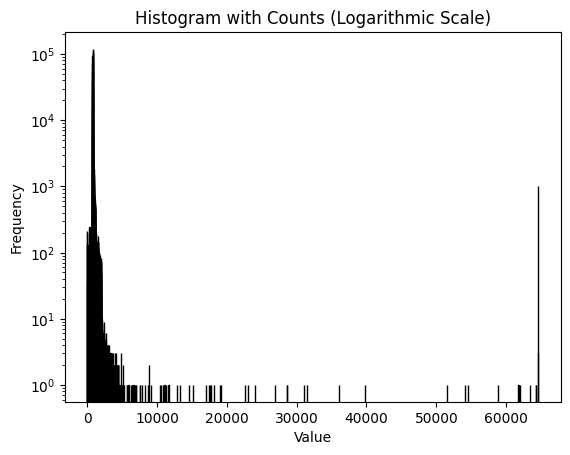

In [85]:
image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1069.fits")
image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1069.fits")
image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1069.fits")
image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1067.fits")  # Linear + plateau
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1068.fits")  # Linear + plateau
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1057.fits")
image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1054.fits")
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1046.fits")
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1034.fits")
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1001.fits")
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1073.fits")
# image = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1032.fits")

bin_width = 10

with fits.open(image) as hdu:
    header = hdu[0].header
    data = hdu[0].data
    
    # number of pixels in image
    xsize = header['NAXIS1']
    # number of overscan columns
    cover = header['COVER']
    # Remove overscan portion
    data = data[0:,0:xsize-cover]
    
    # Calculate number of histogram bins, based on range of data
    minval = np.min(data)
    maxval = np.max(data)
    num_bins = int((maxval-minval)/bin_width) + 1
    
    # Create the histogram -- counts = frequency within each bin, bin_edges = values at bin boundaries
    counts, bin_edges = np.histogram(data, bins=num_bins, )
    
    # Plot histogram using matplotlib
    plot_histo(bin_edges, counts)

Fill the histogram bins with the actual pixel values that fall within their range

In [86]:
# Create a list to store the values in each bin
bins = [[] for _ in range(num_bins)]

# Assign each value to the corresponding bin
for row in data:
    for value in row:
        bin_index = int(np.floor((value - minval) / bin_width))
        bins[bin_index].append(value)

Create a histogram of all the values in just one bin

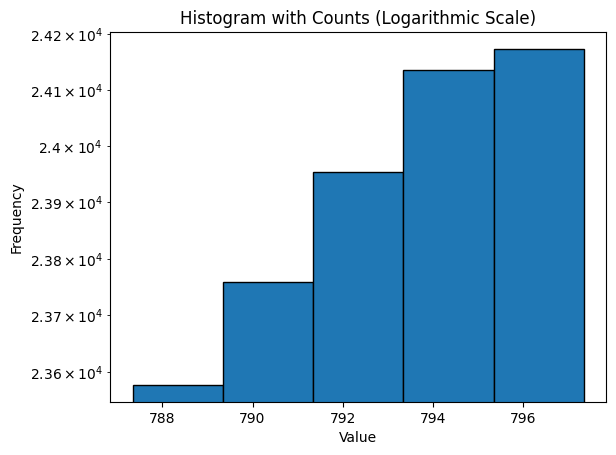

[792.3677, 2.883679]

In [87]:
bin_to_analyze = np.argmax(counts)    # int(num_bins/2)
def analyze_bin(bin_index, plot=False):
    if plot:
        # Create the histogram -- counts = frequency within each bin, bin_edges = values at bin boundaries
        subcounts, subbin_edges = np.histogram(bins[bin_index], bins=int(bin_width/2), )
        # Plot histogram using matplotlib
        plot_histo(subbin_edges, subcounts)
    
    mean = np.mean(bins[bin_index])
    sd = np.std(bins[bin_index])
    return [mean, sd]

analyze_bin(bin_to_analyze, plot=True)

Find the mean and standard deviation for all bins

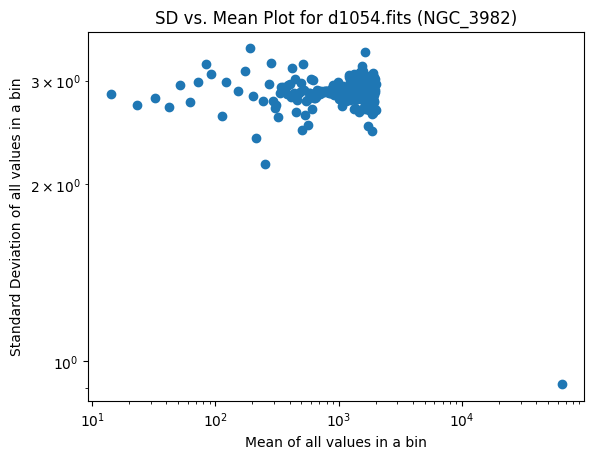

In [88]:
means = []
sds = []
for bin_index in range(len(bins)):
    if len(bins[bin_index]) > 20:
        mean, sd = analyze_bin(bin_index)
        if sd != 0:
            means.append(mean)
            sds.append(sd)

# Plot the scatter plot
plt.scatter(means, sds)
plt.xscale('log')
plt.yscale('log')
# Set the range of the axes
# plt.xlim(0, max(means)*1.2)

# Add titles and labels
plt.title(f'SD vs. Mean Plot for {image.name} ({header["OBJECT"]})')
plt.xlabel('Mean of all values in a bin')
plt.ylabel('Standard Deviation of all values in a bin')

# Show the plot
plt.show()

log(SD) = -0.03 log(mean) + 1.13


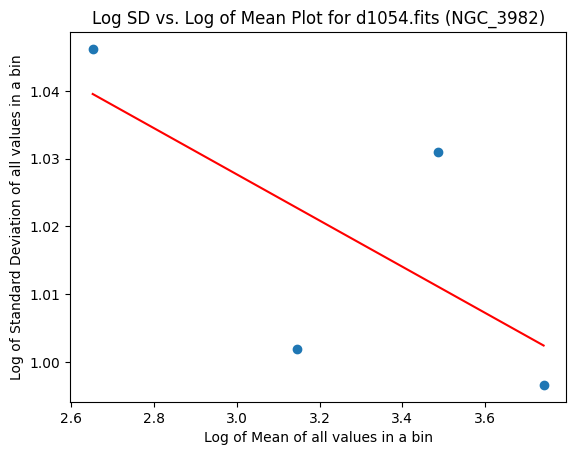

In [89]:
meanlogs = [math.log(mean) for mean in means]
sdlogs = [math.log(sd) for sd in sds]

meanlogs_linear = meanlogs[:4]
sdlogs_linear = sdlogs[:4]

# Calculate the line of best fit
coefficients = np.polyfit(meanlogs_linear, sdlogs_linear, 1)  # 1 means linear fit (degree 1)
polynomial = np.poly1d(coefficients)
line_of_best_fit = polynomial(meanlogs_linear)

print(f"log(SD) = {coefficients[0]:.2f} log(mean) + {coefficients[1]:.2f}")

# Plot the scatter plot
plt.scatter(meanlogs_linear, sdlogs_linear)
# Plot the line of best fit
plt.plot(meanlogs_linear, line_of_best_fit, color='red', label='Line of Best Fit')

# Add titles and labels
plt.title(f'Log SD vs. Log of Mean Plot for {image.name} ({header["OBJECT"]})')
plt.xlabel('Log of Mean of all values in a bin')
plt.ylabel('Log of Standard Deviation of all values in a bin')

# Show the plot
plt.show()

In [90]:
print(counts[:40])

[ 34 137 200 210 132 100  59  37  29  20  27  30  14  19  25  17  24  17
  23  22  24  19  14  21  22  18  30  21  24  51  68 119 197 240 192 159
  86  65  54  41]


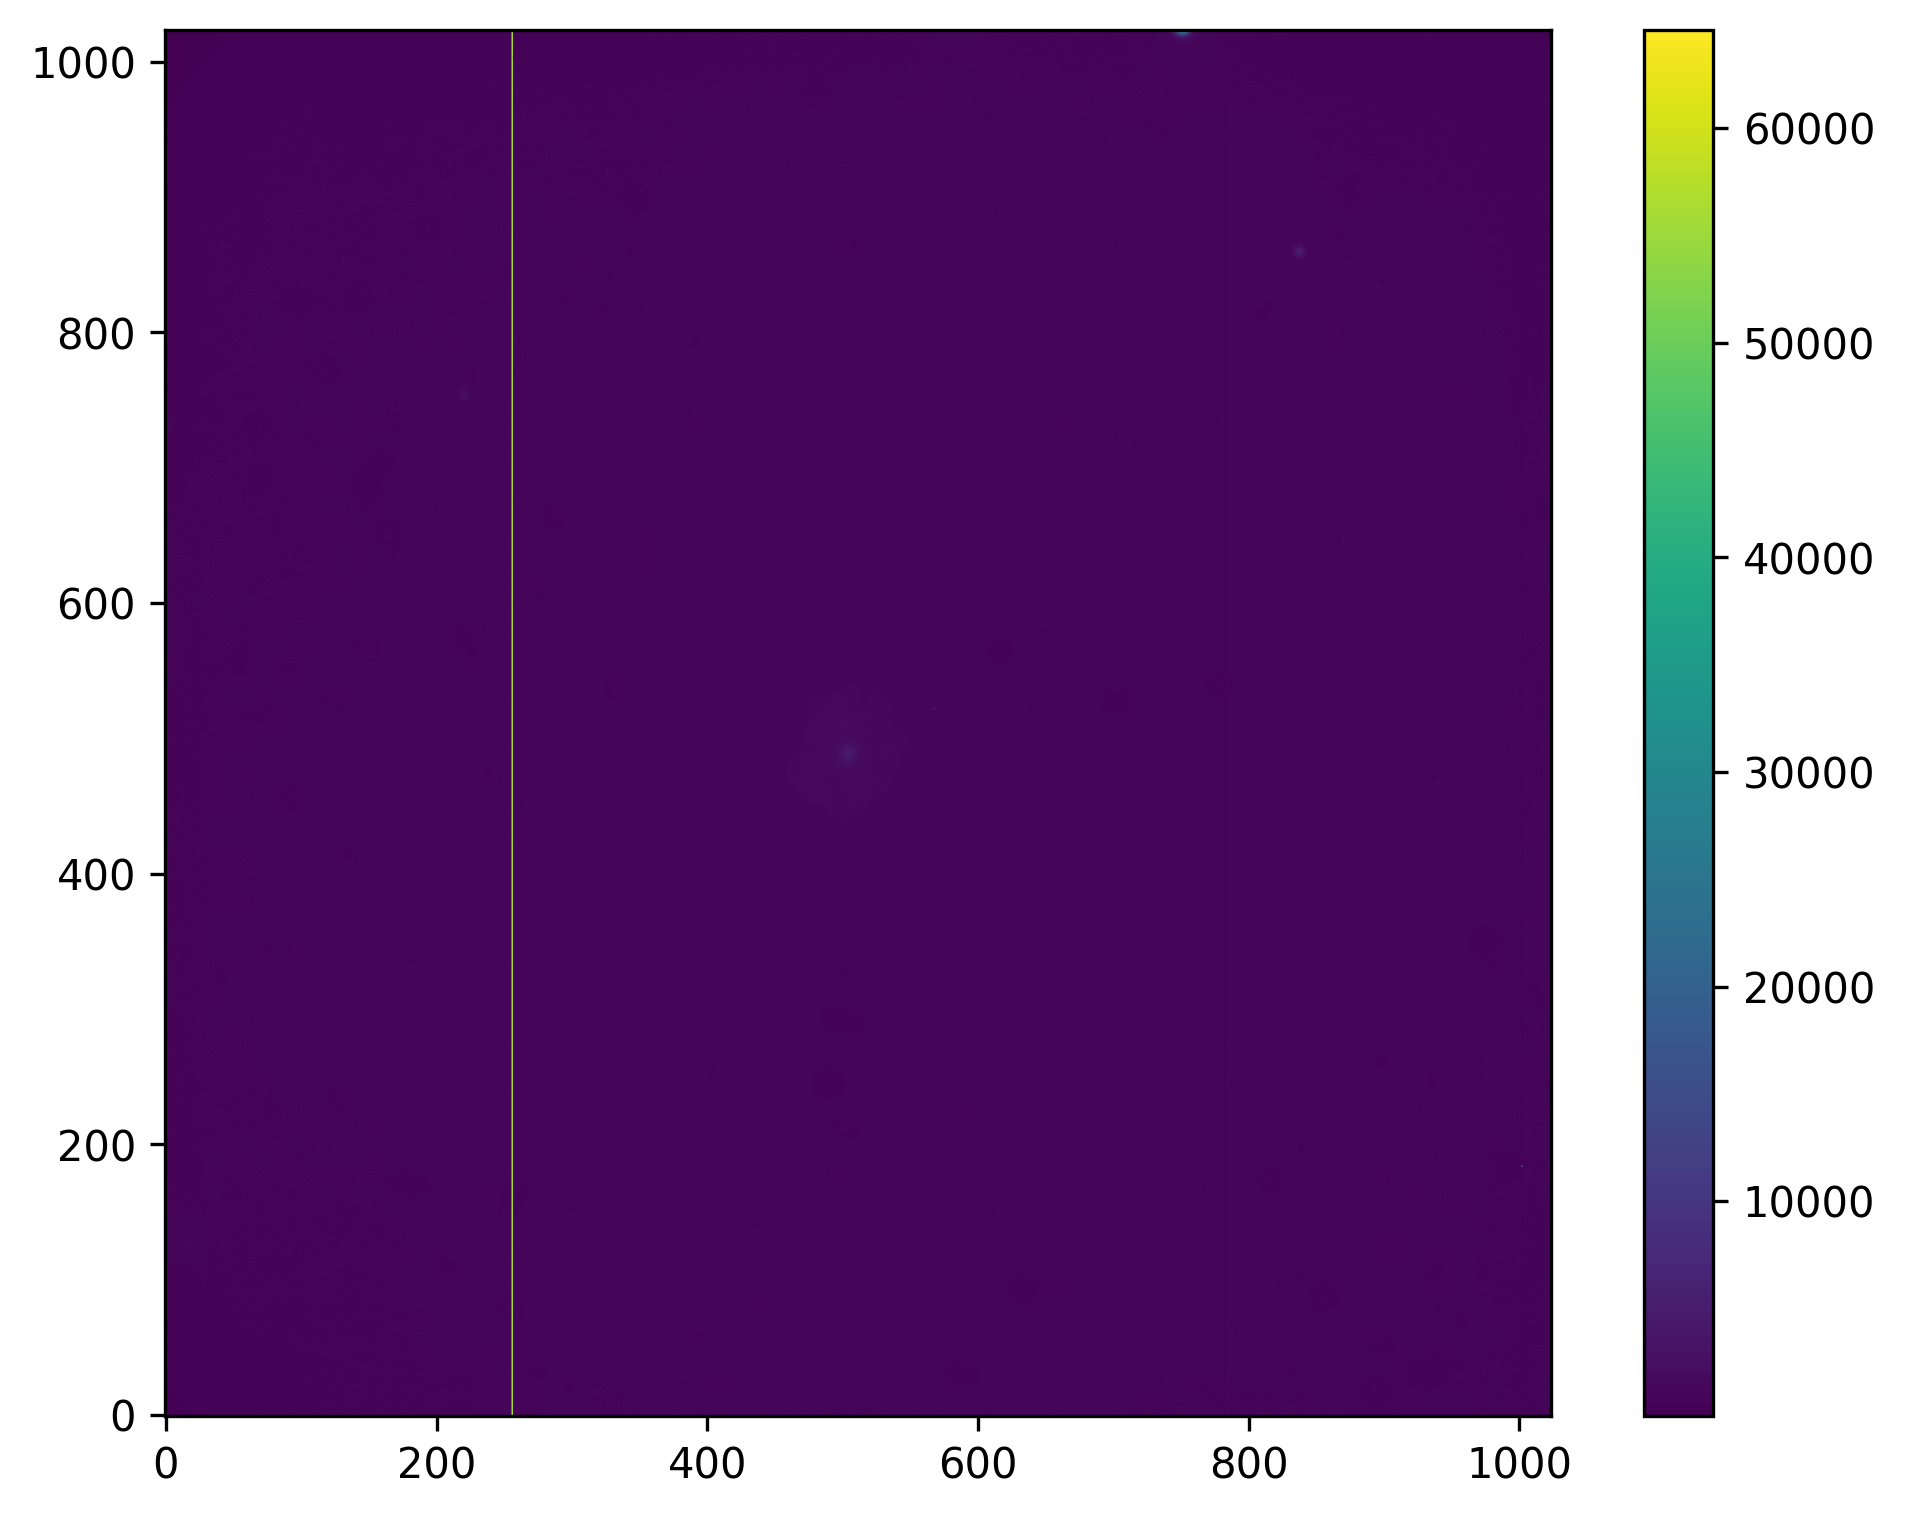

In [91]:
from display_fits import print_fits_info

print_fits_info(image)